### LevSort 
This notebook is an implementation of the algorithm proposed in [1] on page 7. For the idea behind the matching step (II) in the LevSort algorithm consult [this post](https://stackoverflow.com/a/54041501/22817499) on stackoverflow.

[1] “Denoising linear models with permuted data” by A. Pananjady, M. Wainwright and T. A. Courtade, 2017, IEEE International Symposium on Information Theory, 446-450.

In [1]:
# some necessary imports
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from imageHelpers import *

In [2]:
def LevSort(denoisedY, A, returnLevScores=False):
    '''
        The LevSort algorithm from [1]
        
        IN:  denoisedY   <-> np.ndarray which fulfills Y = Pi @ A @ X, where the matrices Pi
                             and X are to be determined and A is as described below
             A           <-> np.ndarray
        
        OUT: Pihat, Xhat <-> both np.ndarray's
        
        
        [1]  “Denoising linear models with permuted data” by A. Pananjady, M. Wainwright and 
             T. A. Courtade, 2017, IEEE International Symposium on Information Theory, 446-450.
    '''
    epsilon = 1e-11
    
    ###
    ### (I) Compute leverage scores l(denoisedY) and l(A).
    ###
    
    # first, compute SVDs for the two matrices
    U_Y, sigmas_Y, _ = np.linalg.svd(denoisedY)
    U_A, sigmas_A, _ = np.linalg.svd(A)
    
    # only consider the reduced forms of the matrices U_Y, U_A
    kY = min([denoisedY.shape[1], sum([1 if sigma > epsilon else 0 for sigma in sigmas_Y])])
    kA = min([A.shape[1], sum([1 if sigma > epsilon else 0 for sigma in sigmas_A])])
    
    U_Y = U_Y[:, :kY]
    U_A = U_A[:, :kA]
    
    # compute the leverage scores
    lY = np.diag(U_Y @ U_Y.T)
    lA = np.diag(U_A @ U_A.T)
    
    ###
    ### (II) Find a permutation matrix Pi that minimises ||lY - Pi @ lA||
    ###
    
    n = len(lY)
    # np.argsort gives the inverse permutation that is needed to go from the unsorted
    # to the sorted array
    piInv_lA = np.argsort(lA) 
    piInv_lY = np.argsort(lY)
    
    # construct the inverse permutation of piInv_lA, i.e. pi_lA
    pi_lA = np.zeros(n, dtype=int)
    for i, piInv_i in enumerate(piInv_lA):
        pi_lA[piInv_i] = i
    
    # to permute the entries of lA such that the euclidean norm is minimal, apply piInv_lY 
    # composed with pi_lA to its indices
    permute_lA_to_lY = [piInv_lY[pi_lA[i]] for i in range(n)]
    
    # finally construct the permutation matrix Pihat
    Pihat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            Pihat[i, j] = 1 if permute_lA_to_lY[j] == i else 0
    
    ###
    ### (III) Compute X = pseudoInverse(Pi @ A) @ Y
    ###
    
    Xhat = np.linalg.pinv(Pihat @ A) @ denoisedY
    
    # if requested, also return the leverage scores lY and lY
    if returnLevScores:
        return Pihat, Xhat, lY, lA
    
    return Pihat, Xhat

In [3]:
def singularValueThresholding(X, lamb):
    U, sigmas, Vh = np.linalg.svd(X, full_matrices=False)
    
    sigmaIndices = sigmas >= lamb
    sigmas = sigmas[sigmaIndices]
    U = U[:, sigmaIndices]
    Vh = Vh[sigmaIndices]
    
    return (U * sigmas) @ Vh

In [4]:
def randomPermutation(rng, n, p=0.5):
    indices = [i for i in range(n)]
    
    for i, j in combinations(indices.copy(), 2):
        # do a coin flip with success prob. p if i and j should get transposed
        if rng.binomial(n=1, p=p/n):
            index_i = indices.index(i)
            index_j = indices.index(j)
            indices[index_j] = i
            indices[index_i] = j

    PiStar = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            PiStar[i, j] = 1 if indices[j] == i else 0

    return PiStar

### Example 1: Matching of corner points before linear transformation

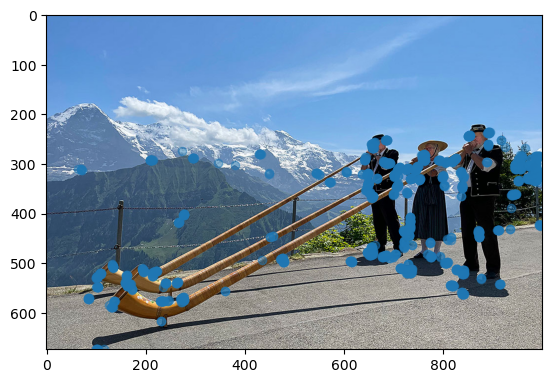

diag(PiStar) / n = 0.78 approX.


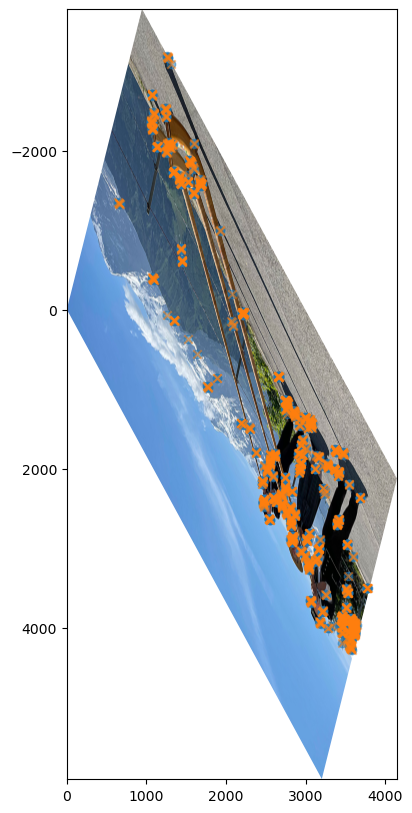

In [23]:
rng = np.random.default_rng(seed=12345)

### detect corners in the picture
A = detectCorners('alphoerner2.jpg')

### plot the detected corners
plotImage('alphoerner2.jpg', A)

### construct the permutation matrix PiStar
n = len(A)
PiStar = randomPermutation(rng, n, p=0.2)
print(f'diag(PiStar) / n = {np.sum(np.diag(PiStar))/n :.02} approX.')

### construct the linear transformation XStar
XStar = np.array([[3.2, 5.9], [1.4, -5.6]])

Y = PiStar @ A @ XStar

Pihat, Xhat = LevSort(Y, A)
Yhat = Pihat @ A @ Xhat

plotTransformedImage('alphoerner2.jpg', XStar, Yhat, Y)

### Example 2: Matching of corner points after linear transformation

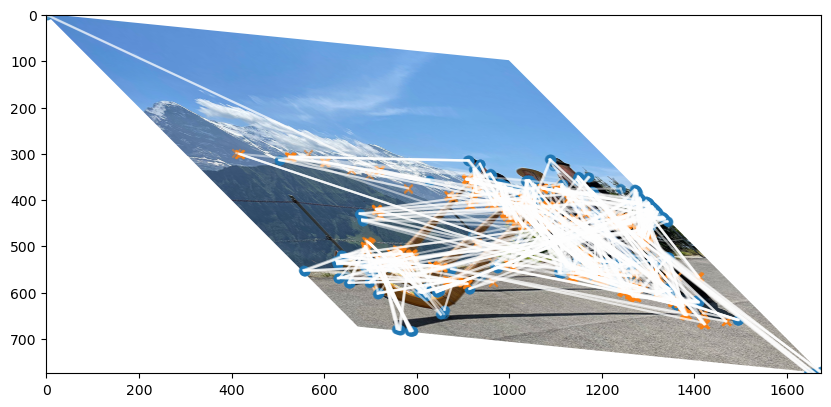

In [24]:
# transformation that is less extreme
XStar = np.array([[1, 0.1], [1, 1]])

# find corners in transformed image
Y = transformImage('alphoerner2.jpg', XStar)

# delete rows of the larger matrix A or Y

rMax = min([len(Y), len(A)])
A_c = A[:rMax]
Y_c = Y[:rMax]

#lamb = 1.1*1*(np.sqrt(Y_c.shape[0]) + np.sqrt(Y_c.shape[1]))
#Y_c = singularValueThresholding(Y_c, lamb)

# again, apply the LevSort algorithm
Pihat, Xhat = LevSort(Y_c, A_c)
Yhat = Pihat @ A_c @ Xhat

plotTransformedImage('alphoerner2.jpg', XStar, Yhat, Y_c, drawLines=True)

### Example 3: Simulation study of the last example

In [25]:
# some error function 
Err = lambda X: np.sum(X**2) / (X.shape[-1] * X.shape[-2])

shear = lambda s: np.array([[1, s], [0, 1]])
scaling = lambda s: np.array([[s, 0], [0, s]])
rotation = lambda alpha: np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])

In [28]:
shears = np.linspace(-3, 3, 40)
alphas = np.linspace(-np.pi, np.pi, 40)

### detect corners in the picture
A = detectCorners('alphoerner2.jpg')

### construct the permutation matrix PiStar
n = len(A)
PiStar = randomPermutation(rng, n, p=0.2)
print(f'diag(PiStar) / n = {np.sum(np.diag(PiStar))/n :.02} approX.')

error = np.zeros((len(shears), len(alphas)))

for i, s in enumerate(shears):
    for j, alpha in enumerate(alphas):
        # build the transformation XStar and transform the original image
        XStar = rotation(alpha) @ shear(s)
        Y, lengthOfTransformedEdge = transformImage('alphoerner2.jpg', XStar, returnLengthTransformedEdge=True)
        
        # cut off remaining rows of the larger of the two
        rMax = min([len(Y), len(A)])
        A_c = A[:rMax]
        Y_c = Y[:rMax]
        
        # do the singular value thresholding
        lamb = 1.1*1*(np.sqrt(Y_c.shape[0]) + np.sqrt(Y_c.shape[1]))
        Y_c = singularValueThresholding(Y_c, lamb)

        # again, apply the LevSort algorithm
        Pihat, Xhat = LevSort(Y_c, A_c)
        Yhat = Pihat @ A_c @ Xhat
        
        # compute the error with Err, which has been defined at the top
        # the data is devided by the length of the scaled bottom edge of the image
        error[i, j] = Err((Yhat - Y_c)/lengthOfTransformedEdge)
    
    print(f'Round {i+1}/{len(shears)} done.', end='\r')

diag(PiStar) / n = 0.83 approX.


In [30]:
scalings = np.logspace(-2, 0, 40)
alphas = np.linspace(-np.pi, np.pi, 40)

error2 = np.zeros((len(scalings), len(alphas)))

for i, s in enumerate(scalings):
    for j, alpha in enumerate(alphas):
        # build the transformation XStar and transform the original image
        XStar = rotation(alpha) @ scaling(s)
        Y, lengthOfTransformedEdge = transformImage('alphoerner2.jpg', XStar, returnLengthTransformedEdge=True)
        
        # cut off remaining rows of the larger of the two
        rMax = min([len(Y), len(A)])
        A_c = A[:rMax]
        Y_c = Y[:rMax]
        
        # do the singular value thresholding
        lamb = 1.1*1*(np.sqrt(Y_c.shape[0]) + np.sqrt(Y_c.shape[1]))
        Y_c = singularValueThresholding(Y_c, lamb)

        # again, apply the LevSort algorithm
        Pihat, Xhat = LevSort(Y_c, A_c)
        Yhat = Pihat @ A_c @ Xhat
        
        # compute the error with Err, which has been defined at the top
        # the data is devided by the length of the scaled bottom edge of the image
        error2[i, j] = Err((Yhat - Y_c)/lengthOfTransformedEdge)
    
    print(f'Round {i+1}/{len(scalings)} done.', end='\r')

The minimal error achieved is 0.014.
The maximal error reached is 0.49.

The minimal error2 achieved is 1.6e-06.
The maximal error2 reached is 0.037.


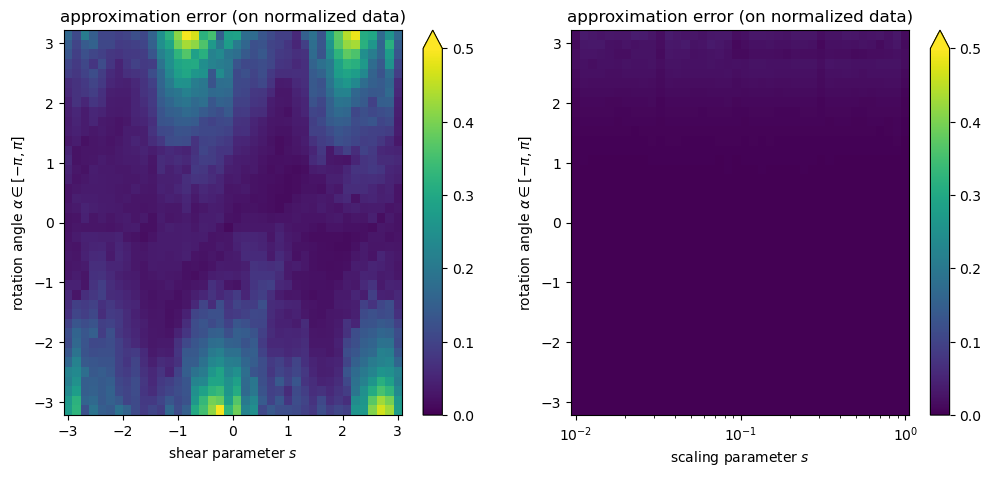

In [31]:
# evaluation

print(f'The minimal error achieved is {np.min(error):.02}.')
print(f'The maximal error reached is {np.max(error):.02}.')

print()

print(f'The minimal error2 achieved is {np.min(error2):.02}.')
print(f'The maximal error2 reached is {np.max(error2):.02}.')


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].set_title('approximation error (on normalized data)')
X0, Y0 =  np.meshgrid(shears, alphas)
plot0 = ax[0].pcolormesh(X0, Y0, error, vmin=0, vmax=0.5)
ax[0].set_xlabel(r'shear parameter $s$')
ax[0].set_ylabel(r'rotation angle $\alpha \in [-\pi, \pi]$')
plt.colorbar(plot0, extend='max')

ax[1].set_title('approximation error (on normalized data)')
X1, Y1 = np.meshgrid(scalings, alphas)
plot1 = ax[1].pcolormesh(X1, Y1, error2, vmin=0, vmax=0.5)
ax[1].set_xscale('log')
ax[1].set_xlabel(r'scaling parameter $s$')
ax[1].set_ylabel(r'rotation angle $\alpha \in [-\pi, \pi]$')
plt.colorbar(plot1, extend='max')

0.01917108176557256


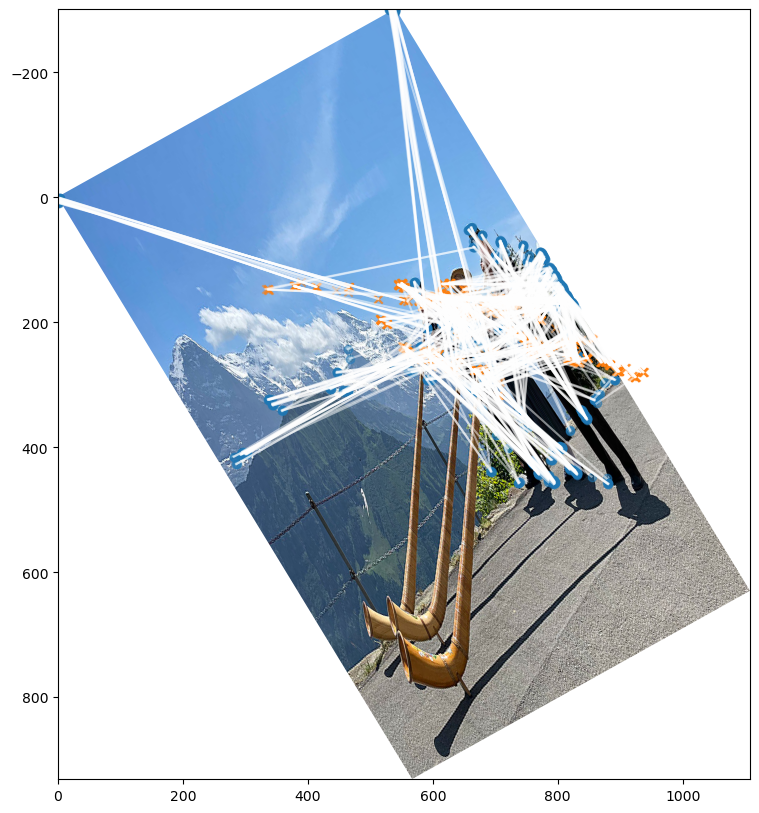

In [33]:
#indexMin = np.argwhere(error == np.min(error))[0]
#indexMax = np.argwhere(error == np.max(error))[0]

XStar = rotation(1) @ shear(1)

# find corners in transformed image
Y, lengthOfTransformedEdge = transformImage('alphoerner2.jpg', XStar, returnLengthTransformedEdge=True)

# delete rows of the larger matrix A or Y
rMax = min([len(Y), len(A)])
A_c = A[:rMax]
Y_c = Y[:rMax]

lamb = 1.1*1*(np.sqrt(Y_c.shape[0]) + np.sqrt(Y_c.shape[1]))
Y_c = singularValueThresholding(Y_c, lamb)

# again, apply the LevSort algorithm
Pihat, Xhat = LevSort(Y_c, A_c)
Yhat = Pihat @ A_c @ Xhat

print(Err((Yhat - Y_c)/lengthOfTransformedEdge))

plotTransformedImage('alphoerner2.jpg', XStar, Yhat, Y_c, drawLines=True)

### Example 4: Simulation study of the asymptotics as $n, m \to \infty$

In [15]:
rng = np.random.default_rng(seed=12345)
Err = lambda X: np.sum(X**2) / (X.shape[0] * X.shape[1])

#ds = np.logspace(1, 4, 20, dtype=int)
ds = np.logspace(1, 3, 5, dtype=int)
ns = np.logspace(1, 3, 20, dtype=int)
ms = np.logspace(1, 3, 20, dtype=int)

sig = 2 # standard deviation of W_ij

errorsAsymptotics = np.zeros((len(ds), len(ns), len(ms)))
errorsAsymptoticsDenoised = errorsAsymptotics.copy()
errorsAsymptoticsWithW = errorsAsymptotics.copy()

for l, d in enumerate(ds):
    for i, n in enumerate(ns):
        for j, m in enumerate(ms):
            
            W = rng.normal(loc=0, scale=sig, size=(n, m))
            A = rng.uniform(low=-20, high=20, size=(n, d))
            XStar = rng.uniform(low=-20, high=20, size=(d, m))
            PiStar = randomPermutation(rng, n, p=0.001)
            
            Y = PiStar @ A @ XStar + W
            
            lamb = 1.1 * sig * (np.sqrt(n) + np.sqrt(m))
            Ydenoised = singularValueThresholding(Y, lamb)
            Pihat, Xhat = LevSort(Ydenoised, A)
            
            Yhat = Pihat @ A @ Xhat
            
            errorsAsymptotics[l, i, j] = Err(PiStar @ A @ XStar - Yhat)
            errorsAsymptoticsDenoised[l, i, j] = Err(PiStar @ A @ XStar - Ydenoised)
            errorsAsymptoticsWithW[l, i, j] = Err(Y - Yhat)
            
        print(f'Round {l*len(ns)+i+1}/{len(ds)*len(ns)} done.', end='\r')

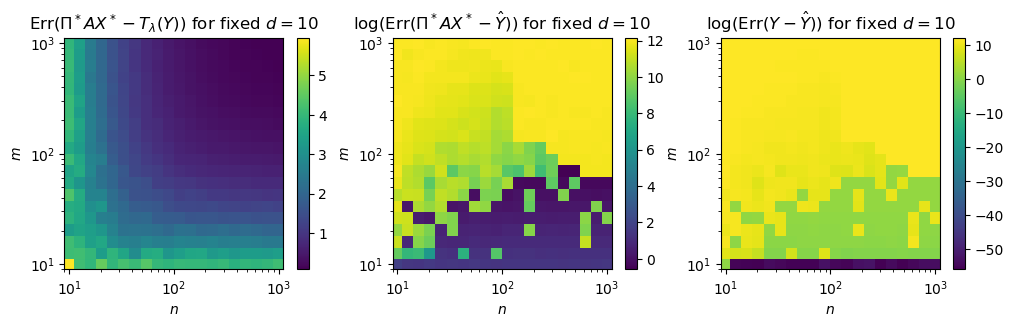

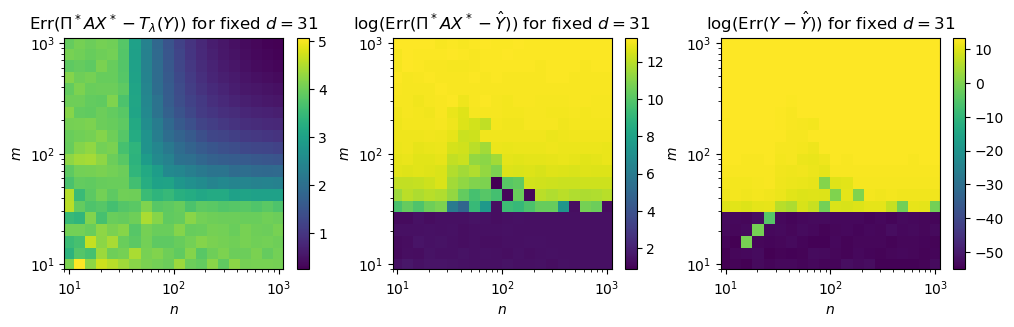

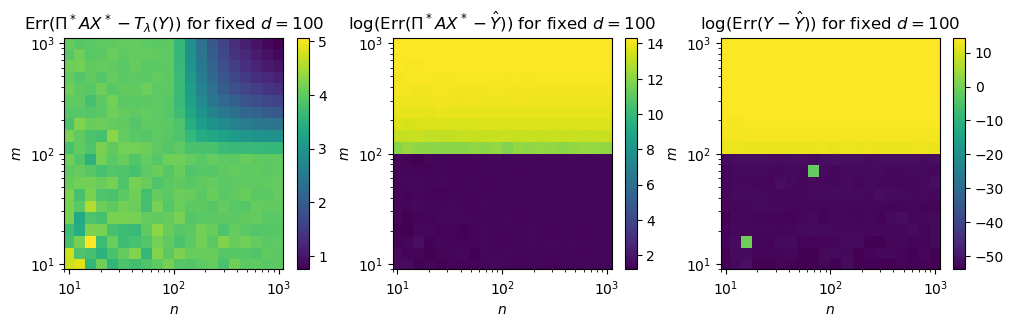

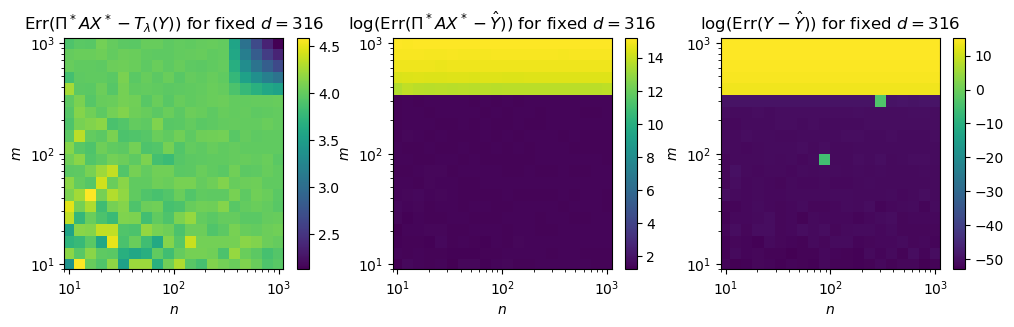

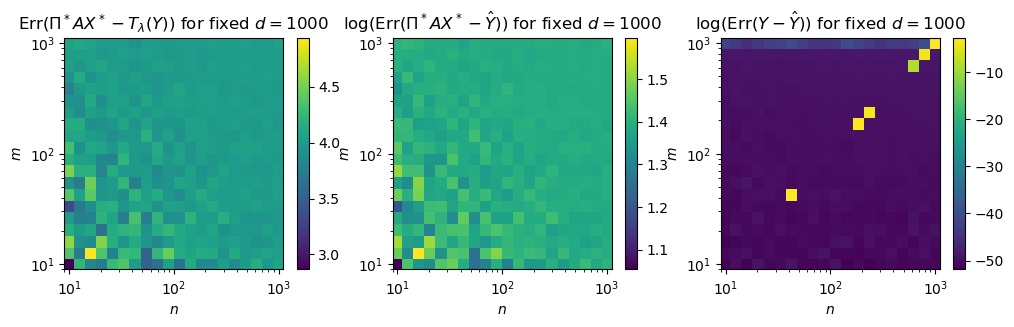

In [17]:
N, M = np.meshgrid(ns, ms)

for i, d in enumerate(ds):
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    
    ax[0].set_title(r'Err($\Pi^* A X^* - T_\lambda(Y)$) for fixed $d = $' + f'{ds[i]}')
    plot0 = ax[0].pcolormesh(N, M, errorsAsymptoticsDenoised[i])
    ax[0].set_xlabel(r'$n$')
    ax[0].set_ylabel(r'$m$')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    plt.colorbar(plot0)

    ax[1].set_title(r'log(Err($\Pi^* A X^* - \hat{Y}$)) for fixed $d = $' + f'{ds[i]}')
    plot1 = ax[1].pcolormesh(N, M, np.log(errorsAsymptotics[i]))
    ax[1].set_xlabel(r'$n$')
    ax[1].set_ylabel(r'$m$')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    plt.colorbar(plot1)
    
    
    ax[2].set_title(r'log(Err($Y - \hat{Y}$)) for fixed $d = $' + f'{ds[i]}')
    plot2 = ax[2].pcolormesh(N, M, np.log(errorsAsymptoticsWithW[i]))
    ax[2].set_xlabel(r'$n$')
    ax[2].set_ylabel(r'$m$')
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    plt.colorbar(plot2)
    

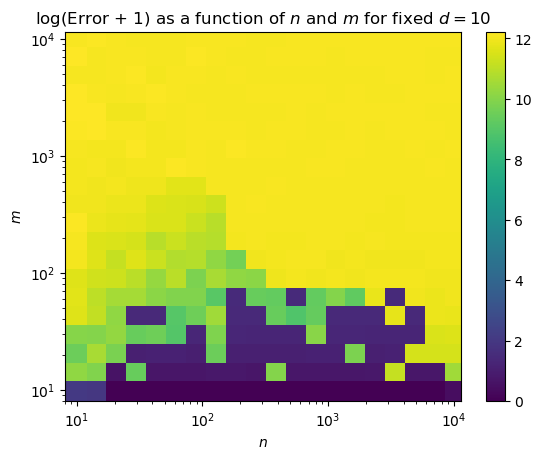

In [14]:
indexD = 0

plt.figure()
plt.title(r'log(Error + 1) as a function of $n$ and $m$ for fixed $d = $' + f'{ds[indexD]}')
N, M = np.meshgrid(ns, ms)
plt.pcolormesh(N, M, np.log(errorsAsymptotics[indexD] + 1))
plt.xlabel(r'$n$')
plt.ylabel(r'$m$')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()